In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json
import os
import tqdm
import dataframe_image as dfi

import warnings
warnings.filterwarnings(action='ignore')

from konlpy.tag import Okt

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import log_loss, accuracy_score,f1_score
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from transformers import *

In [2]:
raw = pd.read_csv('../kyobo2.csv')
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   saleCmdtId        10000 non-null  object
 1   cmdtName          10000 non-null  object
 2   inbukCntt         9726 non-null   object
 3   saleCmdtClstName  10000 non-null  object
dtypes: object(4)
memory usage: 312.6+ KB


In [3]:
raw.head(5)

,saleCmdtId,cmdtName,inbukCntt,saleCmdtClstName
0,S000001803157,불편한 편의점(40만부 기념 벚꽃 에디션),"누적 판매 40만부 돌파, 2022년 가장 사랑받는 소설\n★★★전 서점 종합베스트...",소설
1,S000061694154,아버지의 해방일지,김유정문학상 심훈문학대상 이효석문학상 등을 수상하며 문학성을 두루 입증받은 ‘리얼리...,소설
2,S000061532631,불편한 편의점 2(단풍 에디션),"출간 후 1년이 넘도록 독자의 사랑을 받으며 베스트셀러 상위권을 지키고 있는 소설,...",소설
3,S000061896378,이토록 평범한 미래,작가 김연수가 짧지 않은 침묵을 깨고 신작 소설집 『이토록 평범한 미래』를 출간한다...,소설
4,S000001947482,"오늘 밤, 세계에서 이 사랑이 사라진다 해도","“머리가 아플 정도로 펑펑 울고 말았다.\n반드시, 반드시 읽어야 할 작품이다.” ...",소설


In [4]:
raw.fillna('NAN', inplace=True)

In [5]:
le = LabelEncoder()

raw.iloc[:,-1] = le.fit_transform(raw.iloc[:,-1])

raw.head(1).T

,0
saleCmdtId,S000001803157
cmdtName,불편한 편의점(40만부 기념 벚꽃 에디션)
inbukCntt,"누적 판매 40만부 돌파, 2022년 가장 사랑받는 소설\n★★★전 서점 종합베스트..."
saleCmdtClstName,1


In [6]:
for i, label in enumerate(le.classes_):
    print(i, label)
    print(len(raw[raw['saleCmdtClstName']==i]))

0 경제/경영
1200
1 소설
4400
2 어린이(초등)
1900
3 인문
1100
4 자기계발
1400


In [7]:
X = raw.iloc[:,1:-1]
y = raw.iloc[:,-1]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y ,
                                                   test_size=0.2,
                                                   random_state=2022)

In [9]:
X_train.head(1)

,cmdtName,inbukCntt
5516,마인크래프트 전투 핸드북,"마인크래프트는 여러 가지 블록으로 이루어진 자원을 이용해 멋진 건축물을 만들거나, ..."


In [10]:
X_train['data'] = X_train['cmdtName'] + X_train['inbukCntt']
X_test['data'] = X_test['cmdtName'] + X_test['inbukCntt']

In [11]:
print(X_train.shape)
print(X_test.shape)

(8000, 3)
(2000, 3)


In [12]:
X_train.head(3)

,cmdtName,inbukCntt,data
5516,마인크래프트 전투 핸드북,"마인크래프트는 여러 가지 블록으로 이루어진 자원을 이용해 멋진 건축물을 만들거나, ...",마인크래프트 전투 핸드북마인크래프트는 여러 가지 블록으로 이루어진 자원을 이용해 멋...
1255,기억 서점,"대학교수이자 문학박사, 고서적 수집가로 왕성한 활동을 하고 있는 유명우 교수는 지나...","기억 서점대학교수이자 문학박사, 고서적 수집가로 왕성한 활동을 하고 있는 유명우 교..."
4319,오만과 편견 3(미니북)(초판본)(1894년 오리지널 초판본 표지디자인),베넷 가 다섯 자매의 첫째 딸인 제인은 온순하고 순진했다. 둘째 딸인 엘리자베스는 ...,오만과 편견 3(미니북)(초판본)(1894년 오리지널 초판본 표지디자인)베넷 가 다...


In [13]:
X_train['data'] = X_train['data'].apply(lambda x : re.sub("[^가-힣ㄱ-하-ㅣ\s]","",x))
X_train['data'] = X_train['data'].apply(lambda x : re.sub("\n"," ",x))

X_test['data'] = X_test['data'].apply(lambda x : re.sub("[^가-힣ㄱ-하-ㅣ\s]","",x))
X_test['data'] = X_test['data'].apply(lambda x : re.sub("\n"," ",x))

In [14]:
def get_num_words_per_sample(sample_texts):
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

def plot_sample_length_distribution(sample_texts):
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

In [15]:
get_num_words_per_sample(X_train['data'])

122.0

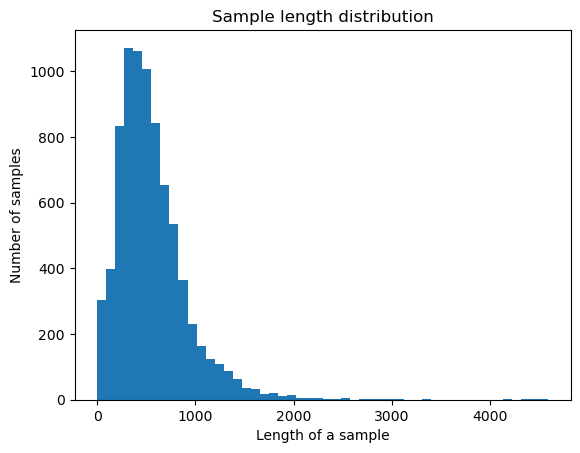

In [16]:
plot_sample_length_distribution(X_train['data'])

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif

In [18]:
Ngram_range = (1,2)
top_k = 50000
token_mode = 'word'
min_document_freq = 2

In [19]:
def train_ngram_vectorize():
    kwargs = {
        'ngram_range' : Ngram_range,
        'dtype' : 'int32',
        'strip_accents' : False,
        'lowercase' : False,
        'decode_error' : 'replace',
        'analyzer' : token_mode,
        'min_df' : min_document_freq,
        
    }
    
    vectorizer = TfidfVectorizer(**kwargs)
    
    x_train = vectorizer.fit_transform(X_train['data'])
    x_test = vectorizer.transform(X_test['data'])
    
    selector = SelectKBest(f_classif, k=min(top_k, x_train.shape[1]))
    selector.fit(x_train, y_train.values)
    
    x_train = selector.transform(x_train).astype('float32')
    x_test = selector.transform(x_test).astype('float32')
    
    return x_train, x_test

In [20]:
x_train, x_test = train_ngram_vectorize()

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [22]:
def single_dense(x,units):
    fc = Dense(units, activation = None)(x)
    batch = BatchNormalization()(fc)
    relu = ReLU()(batch)
    dr = Dropout(0.2)(relu)
    
    return dr


def create_model(input_shape, num_labels, learning_rate):
    x_in = tf.keras.Input(shape=(input_shape,))
    fc = single_dense(x_in, 256)
    fc = single_dense(fc, 128)
    fc = single_dense(fc, 64)
    
    x_out = Dense(num_labels, activation = 'softmax')(fc)
    
    model = Model(x_in, x_out)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics = ['acc'])
    
    return model

In [23]:
basic_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
            ]
basic_model = create_model(x_train.shape[1], 5, 1e-3)
bsic_history = basic_model.fit(x_train.toarray(),
                   y_train,
                   epochs=300,
                   callbacks=basic_callbacks,
                   verbose=1,
                   batch_size=1024)


Epoch 1/300
8/8 [==============================] - 6s 408ms/step - loss: 1.2244 - acc: 0.5512
Epoch 2/300
8/8 [==============================] - 3s 403ms/step - loss: 0.4898 - acc: 0.8806
Epoch 3/300
8/8 [==============================] - 3s 380ms/step - loss: 0.2736 - acc: 0.9526
Epoch 4/300
8/8 [==============================] - 3s 381ms/step - loss: 0.1694 - acc: 0.9735
Epoch 5/300
8/8 [==============================] - 3s 366ms/step - loss: 0.1163 - acc: 0.9824
Epoch 6/300
8/8 [==============================] - 3s 360ms/step - loss: 0.0875 - acc: 0.9845
Epoch 7/300
8/8 [==============================] - 3s 366ms/step - loss: 0.0719 - acc: 0.9876
Epoch 8/300
8/8 [==============================] - 3s 360ms/step - loss: 0.0622 - acc: 0.9883
Epoch 9/300
8/8 [==============================] - 3s 381ms/step - loss: 0.0550 - acc: 0.9874
Epoch 10/300
8/8 [==============================] - 3s 381ms/step - loss: 0.0516 - acc: 0.9876
Epoch 11/300
8/8 [==============================] - 3s 395m

In [24]:
basic_prediction = basic_model.predict(x_test.toarray())

63/63 [==============================] - 1s 12ms/step


In [27]:
basic_pred = np.argmax(basic_prediction,axis =1)

In [28]:
r_a = (basic_pred == y_test).mean()
r_a

0.4305

In [29]:
basic_callbacks2 = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
            ]
basic_model2 = create_model(x_train.shape[1], 5, 1e-3)
basic_history2 = basic_model2.fit(x_train.toarray(),
                   y_train,
                   epochs=300,
                   callbacks=basic_callbacks2,
                   verbose=1,
                   validation_split=0.33,
                   batch_size=512)

Epoch 1/300
11/11 [==============================] - 5s 323ms/step - loss: 1.1780 - acc: 0.5734 - val_loss: 1.5746 - val_acc: 0.5131
Epoch 2/300
11/11 [==============================] - 3s 293ms/step - loss: 0.4347 - acc: 0.9076 - val_loss: 1.4861 - val_acc: 0.4881
Epoch 3/300
11/11 [==============================] - 3s 289ms/step - loss: 0.2224 - acc: 0.9672 - val_loss: 1.3865 - val_acc: 0.4714
Epoch 4/300
11/11 [==============================] - 3s 311ms/step - loss: 0.1334 - acc: 0.9840 - val_loss: 1.3053 - val_acc: 0.4585
Epoch 5/300
11/11 [==============================] - 3s 296ms/step - loss: 0.0879 - acc: 0.9882 - val_loss: 1.2500 - val_acc: 0.4529
Epoch 6/300
11/11 [==============================] - 3s 291ms/step - loss: 0.0658 - acc: 0.9899 - val_loss: 1.2195 - val_acc: 0.4521
Epoch 7/300
11/11 [==============================] - 3s 302ms/step - loss: 0.0578 - acc: 0.9897 - val_loss: 1.2071 - val_acc: 0.4502
Epoch 8/300
11/11 [==============================] - 3s 289ms/step - 

11/11 [==============================] - 3s 288ms/step - loss: 0.0192 - acc: 0.9938 - val_loss: 0.3217 - val_acc: 0.9159
Epoch 63/300
11/11 [==============================] - 3s 282ms/step - loss: 0.0209 - acc: 0.9920 - val_loss: 0.3253 - val_acc: 0.9152
Epoch 64/300
11/11 [==============================] - 3s 282ms/step - loss: 0.0196 - acc: 0.9925 - val_loss: 0.3431 - val_acc: 0.9095
Epoch 65/300
11/11 [==============================] - 3s 281ms/step - loss: 0.0206 - acc: 0.9903 - val_loss: 0.3266 - val_acc: 0.9148
Epoch 66/300
11/11 [==============================] - 3s 283ms/step - loss: 0.0222 - acc: 0.9909 - val_loss: 0.3209 - val_acc: 0.9171
Epoch 67/300
11/11 [==============================] - 3s 281ms/step - loss: 0.0199 - acc: 0.9914 - val_loss: 0.3320 - val_acc: 0.9148
Epoch 68/300
11/11 [==============================] - 3s 281ms/step - loss: 0.0209 - acc: 0.9916 - val_loss: 0.3278 - val_acc: 0.9159
Epoch 69/300
11/11 [==============================] - 3s 281ms/step - loss:

In [30]:
basic_prediction2 = basic_model2.predict(x_test.toarray())
basic_pred2 = np.argmax(basic_prediction2,axis =1)
r_b = (basic_pred2 == y_test).mean()

63/63 [==============================] - 1s 13ms/step


In [31]:
r_b

0.854

In [32]:
raw2 = pd.read_csv('../kyobo3.csv')
raw2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   saleCmdtId    10000 non-null  object
 1   chrcIntcCntt  8979 non-null   object
dtypes: object(2)
memory usage: 156.4+ KB


In [33]:
raw2.fillna('NAN', inplace=True)

In [34]:
raw_ = raw.sort_values('saleCmdtId')
raw_['chrcIntcCntt'] = raw2.sort_values('saleCmdtId')['chrcIntcCntt']
raw_.reset_index(drop=True, inplace=True)
raw_

,saleCmdtId,cmdtName,inbukCntt,saleCmdtClstName,chrcIntcCntt
0,S000000033706,OYO 카드(소),『성경암송 구절 기록 카드』는 성경의 구절을 암송할 수 있도록 구성하였다. 빈카드 ...,2,NAN
1,S000000332556,다면체 종이접기,다면체 종이접기를 하면 두뇌개발과 예술적 감각이 향상되고 자기효능감이 높아져요!\r...,2,오랫동안 어린이 친구들을 위한 만화 시나리오를 써 왔다. 쓴 책으로는 《도티&잠뜰:...
2,S000000332557,블레이드 종이접기,「블레이드 종이접기」는 종이문화재단 세계종이접기창작개발원 서원선 원장님이 어린이들을...,2,"한국종이접기협회 창작개발위원장 및 이사, 한국창작종이문화원 원장을 역임했다. 일본 ..."
3,S000000339989,하나님의 자녀가 되고 싶으세요?,『하나님의 자녀가 되고 싶으세요?』는 〈하나님은 여러분을 사랑하시며 여러분을 위한 ...,2,NAN
4,S000000347099,흔한남매 유튜브 연습장,구독자 수 185만 명 돌파! ‘흔한남매’를 사랑하는 냐하들은 아주아주 많습니다. ...,2,NAN
...,...,...,...,...,...
9995,S000200602955,언제든지 스마일,중학교 도덕 교과서 수록 《류명성 통일빵집》의 작가 박경희의 첫 역사소설!\n중학교...,1,출간작으로 『속도의 안내자』 등이 있다.
9996,S000200605951,인류 밖에서 찾은 완벽한 리더들,살아가는 데 필요한 모든 교양 지식을 한데 모았다! 대한민국 대표 교수진이 펼치는 ...,3,"한국외국어대학교 프랑스어과 박사 과정을 수료하고 한국외국어대학교, 강원대학교, 상명..."
9997,S000200606066,서울을 팔고 도쿄를 샀습니다,"‘조물주 위에 건물주’라는 말이 유행어가 될 만큼 우리나라에서 부동산, 그것도 건물...",0,936년 경상북도 대구 출생. 1956년 경기고등학교 졸업. 1960년 연세대 상경...
9998,S000200606093,무조건 합격하는 암기의 기술,시험공부를 하는 사람에게 암기는 필수다. 합격을 위해 방대한 양의 공부를 해야 하고...,4,일본의 세계적인 기업가로 일본에서 가장 존경받는 경영자 중 한 사람이자 살아있는 ‘...


In [35]:
raw_['data'] = raw_['cmdtName'] + raw_['inbukCntt'] + raw_['chrcIntcCntt']
raw_['data'] = raw_['data'].apply(lambda x : re.sub("[^가-힣ㄱ-하-ㅣ\s]","",x))
raw_['data'] = raw_['data'].apply(lambda x : re.sub("\n"," ",x))
raw_ = raw_[['data', 'saleCmdtClstName']]
raw_

,data,saleCmdtClstName
0,카드소성경암송 구절 기록 카드는 성경의 구절을 암송할 수 있도록 구성하였다 빈카드...,2
1,다면체 종이접기다면체 종이접기를 하면 두뇌개발과 예술적 감각이 향상되고 자기효능감이...,2
2,블레이드 종이접기블레이드 종이접기는 종이문화재단 세계종이접기창작개발원 서원선 원장님...,2
3,하나님의 자녀가 되고 싶으세요하나님의 자녀가 되고 싶으세요는 하나님은 여러분을 사랑...,2
4,흔한남매 유튜브 연습장구독자 수 만 명 돌파 흔한남매를 사랑하는 냐하들은 아주아주 ...,2
...,...,...
9995,언제든지 스마일중학교 도덕 교과서 수록 류명성 통일빵집의 작가 박경희의 첫 역사소설...,1
9996,인류 밖에서 찾은 완벽한 리더들살아가는 데 필요한 모든 교양 지식을 한데 모았다 대...,3
9997,서울을 팔고 도쿄를 샀습니다조물주 위에 건물주라는 말이 유행어가 될 만큼 우리나라에...,0
9998,무조건 합격하는 암기의 기술시험공부를 하는 사람에게 암기는 필수다 합격을 위해 방대...,4


In [36]:
X_train, X_test, y_train, y_test = train_test_split(raw_.iloc[:,0], raw_.iloc[:,-1] ,
                                                   test_size=0.2,
                                                   random_state=2022)

In [37]:
get_num_words_per_sample(X_train)

210.0

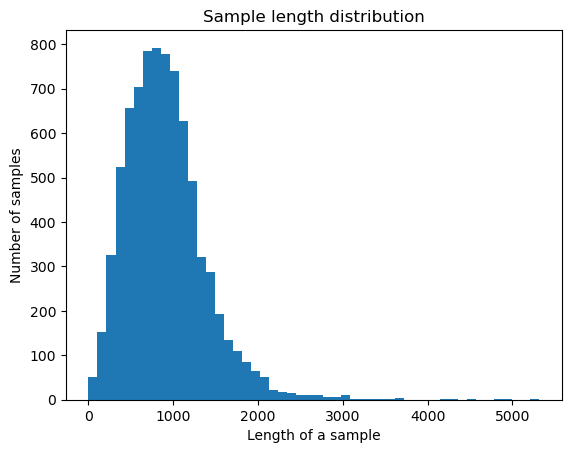

In [38]:
plot_sample_length_distribution(X_train)

In [39]:
def train_ngram_vectorize():
    kwargs = {
        'ngram_range' : Ngram_range,
        'dtype' : 'int32',
        'strip_accents' : False,
        'lowercase' : False,
        'decode_error' : 'replace',
        'analyzer' : token_mode,
        'min_df' : min_document_freq,
        
    }
    
    vectorizer = TfidfVectorizer(**kwargs)
    
    x_train = vectorizer.fit_transform(X_train)
    x_test = vectorizer.transform(X_test)
    
    selector = SelectKBest(f_classif, k=min(top_k, x_train.shape[1]))
    selector.fit(x_train, y_train.values)
    
    x_train = selector.transform(x_train).astype('float32')
    x_test = selector.transform(x_test).astype('float32')
    
    return x_train, x_test

x_train, x_test = train_ngram_vectorize()

In [40]:
new_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
            ]
new_model = create_model(x_train.shape[1], 5, 1e-3)
history = new_model.fit(x_train.toarray(),
                   y_train,
                   epochs=300,
                   callbacks=new_callbacks,
                   verbose=1,
                   validation_split=0.33,
                   batch_size=512)

Epoch 1/300
11/11 [==============================] - 5s 316ms/step - loss: 1.0691 - acc: 0.6341 - val_loss: 1.5577 - val_acc: 0.6937
Epoch 2/300
11/11 [==============================] - 3s 287ms/step - loss: 0.3987 - acc: 0.9246 - val_loss: 1.4549 - val_acc: 0.6134
Epoch 3/300
11/11 [==============================] - 3s 284ms/step - loss: 0.2077 - acc: 0.9677 - val_loss: 1.3478 - val_acc: 0.5441
Epoch 4/300
11/11 [==============================] - 3s 286ms/step - loss: 0.1275 - acc: 0.9808 - val_loss: 1.2668 - val_acc: 0.4934
Epoch 5/300
11/11 [==============================] - 3s 285ms/step - loss: 0.0889 - acc: 0.9869 - val_loss: 1.2119 - val_acc: 0.4684
Epoch 6/300
11/11 [==============================] - 3s 290ms/step - loss: 0.0661 - acc: 0.9901 - val_loss: 1.1785 - val_acc: 0.4585
Epoch 7/300
11/11 [==============================] - 3s 282ms/step - loss: 0.0515 - acc: 0.9927 - val_loss: 1.1619 - val_acc: 0.4555
Epoch 8/300
11/11 [==============================] - 3s 286ms/step - 

In [41]:
new_prediction = new_model.predict(x_test.toarray())
new_pred = np.argmax(new_prediction,axis =1)
r_c = (new_pred == y_test).mean()

63/63 [==============================] - 1s 12ms/step


In [42]:
r_c

0.887

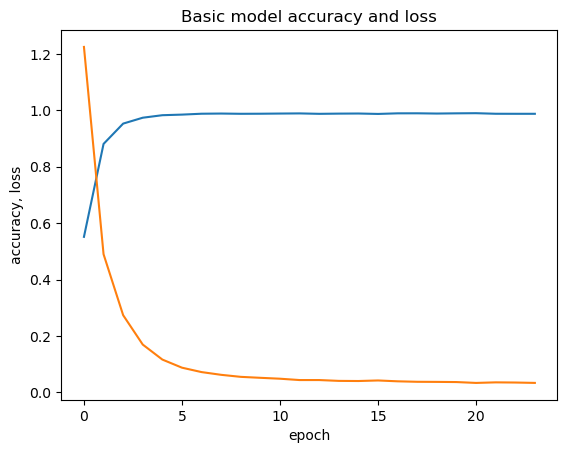

In [43]:
plt.plot(bsic_history.history['acc'])
plt.plot(bsic_history.history['loss'])
plt.title('Basic model accuracy and loss')
plt.ylabel('accuracy, loss')
plt.xlabel('epoch')
# plt.savefig('./Basic model.png')
plt.show()

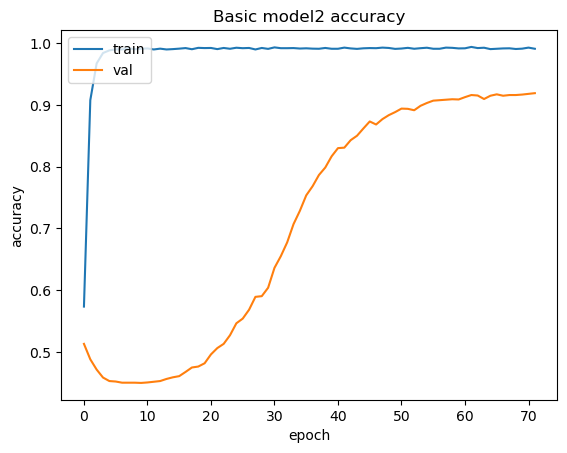

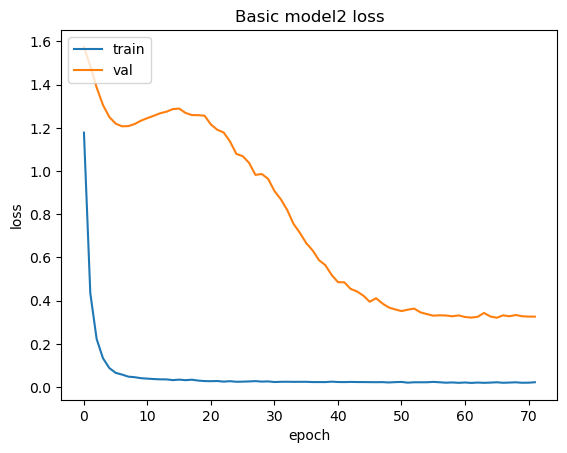

In [44]:
plt.plot(basic_history2.history['acc'])
plt.plot(basic_history2.history['val_acc'])
plt.title('Basic model2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig('./Basic2 acc model.png')
plt.show()

plt.plot(basic_history2.history['loss'])
plt.plot(basic_history2.history['val_loss'])
plt.title('Basic model2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig('./Basic2 loss model.png')
plt.show()

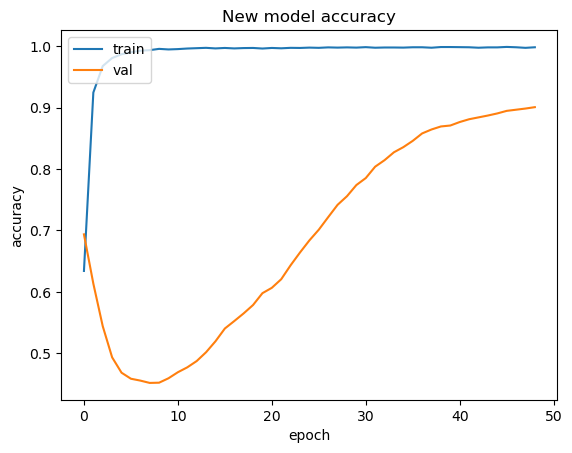

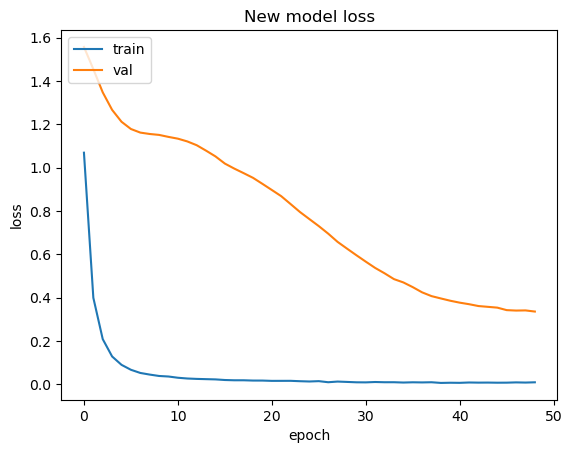

In [45]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('New model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig('./New acc model.png')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('New model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig('./New loss model.png')
plt.show()

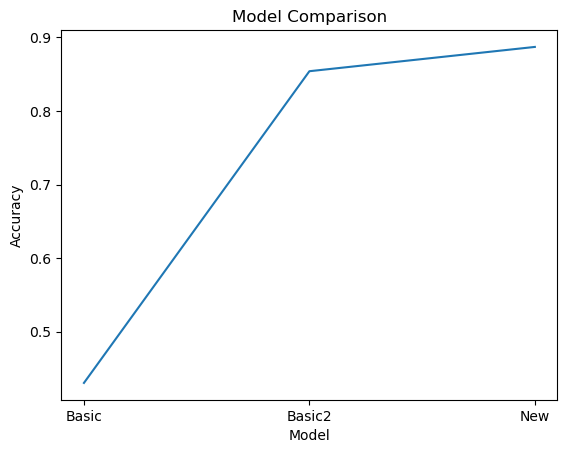

In [46]:
plt.plot(['Basic', 'Basic2', 'New'], [r_a, r_b, r_c])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison');
# plt.savefig('./Model acc.png');